In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import contractions

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sent_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('../data/political_opinionated.csv')

## Sentiment Scores

In [3]:
def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'^>.*$', '', text, flags=re.MULTILINE)   # remove quotes
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions (@user)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [4]:
# Apply the normalization function to the 'text' column
df['normalized_text'] = df['text'].apply(normalize_text)

In [5]:
sia = SentimentIntensityAnalyzer()
# Sentiment analysis function
def analyze_text_vader(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0

    sentences = sent_tokenize(text)  # Split text into sentences
    sentiment_scores = [sia.polarity_scores(sentence)['compound'] for sentence in sentences]

    if not sentiment_scores:
        return 0  # Neutral sentiment
    else:
        return np.mean(sentiment_scores)

In [6]:
df['vader_sentiment_avg'] = df['normalized_text'].apply(lambda x: analyze_text_vader(x))

## SVM

### Vectorizer

In [7]:
def custom_preprocessor(text):
    text = contractions.fix(text.lower())                   # fix contractions and lowercase
    text = re.sub(r'^>.*$', '', text, flags=re.MULTILINE)   # remove quotes
    text = re.sub(r'http\S+|www\S+', '', text)              # remove URLs
    text = re.sub(r'@\w+', '', text)                        # remove mentions
    text = re.sub(r'[^a-z\s]', '', text)                    # remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()                # clean extra whitespace
    return text

In [8]:
tfidf_vectorizer = CountVectorizer(
    preprocessor=custom_preprocessor,
    stop_words='english',
    max_features=1000
)

### Pipelines

In [9]:
X = df[['text', 'vader_sentiment_avg']]
y = df['political_alignment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42
                                                    , stratify=y)

In [10]:
preprocessing_tfidf_sentiment = ColumnTransformer([
    ('text', tfidf_vectorizer, 'text'),
    ('sentiment', StandardScaler(), ['vader_sentiment_avg'])
])

In [11]:
preprocessing_tfidf = ColumnTransformer([
    ('text', tfidf_vectorizer, 'text')
])

In [12]:
pipeline = Pipeline([
    ('features', preprocessing_tfidf),
    ('model', LinearSVC(max_iter=20000, C=0.001))
])

In [13]:
hyperparameters = {
    'features__text__min_df': [10],
    'features__text__ngram_range': [(1,1), (1,2), (1,3)], 
    'model__loss': ['squared_hinge']
}

In [14]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=hyperparameters,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
)

grid.fit(X_train[['text', 'vader_sentiment_avg']], y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        ColumnTransformer(transformers=[('text',
                                                                         CountVectorizer(max_features=1000,
                                                                                         preprocessor=<function custom_preprocessor at 0x00000299BB231440>,
                                                                                         stop_words='english'),
                                                                         'text')])),
                                       ('model',
                                        LinearSVC(C=0.001, max_iter=20000))]),
             n_jobs=-1,
             param_grid={'features__text__min_df': [10],
                         'features__text__ngram_range': [(1, 1), (1, 2),
                                                         (1, 3)],
                         'model__loss': ['squared_hinge']},
             scoring='accuracy', verbose=2)

In [15]:
print("Best Params:", grid.best_params_)
print("Best Cross-Validated Accuracy:", grid.best_score_)

Best Params: {'features__text__min_df': 10, 'features__text__ngram_range': (1, 2), 'model__loss': 'squared_hinge'}
Best Cross-Validated Accuracy: 0.6379871890961272


In [16]:
# Save cv results as a DataFrame
# hyper_df = pd.DataFrame(grid.cv_results_)

# plt.figure(figsize=(8,5))
# plt.plot(hyper_df["param_model__C"], hyper_df["mean_test_score"], marker='o')
# plt.xlabel("C value (inverse regularization strength)")
# plt.ylabel("Mean CV Score")
# plt.title("Effect of C on SVM Performance")
# plt.grid(True)
# plt.show()

In [17]:
y_pred = grid.predict(X_test[['text', 'vader_sentiment_avg']])

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.86      0.73       715
           1       0.62      0.32      0.42       518

    accuracy                           0.63      1233
   macro avg       0.63      0.59      0.57      1233
weighted avg       0.63      0.63      0.60      1233



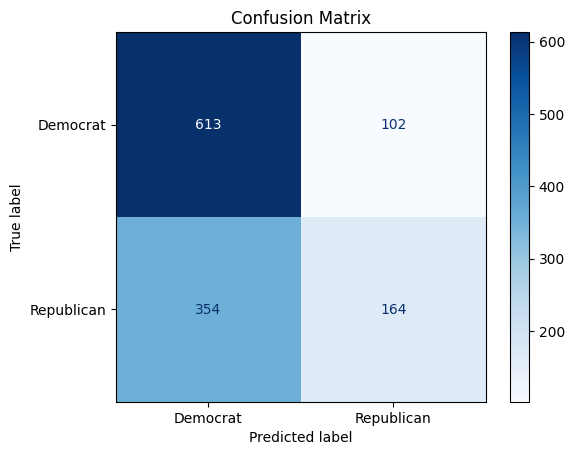

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Democrat', 'Republican'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()